In [131]:
import linsolve
import tf_linsolve
import scipy
import tensorflow as tf
import numpy as np
import pylab as plt
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [168]:
x = np.linspace(0, 2 * np.pi, 10000)
g = np.cos(x) + 1j * np.sin(x)
h = np.sin(x) + 1j * np.cos(x)
i = x + 1j * x
j = -x - 1j * x
k = np.cos(x) - 1j * x
data = {
    "g + h": g + h,
    "g + i": g + i,
    "i + h": i + h,
    "i + g + h": i + g + h,
    "k + j": k + j,
    "i + j": i + j,
}
wgts = {k: np.random.uniform(0.9, 1.1, v.shape[0]) for k, v in data.items()}

In [169]:
ls = linsolve.LinearSolver(data)
tfls = tf_linsolve.LinearSolver(data)

In [104]:
%time solution = ls.solve()

CPU times: user 8.19 ms, sys: 4.39 ms, total: 12.6 ms
Wall time: 4.24 ms


In [105]:
%time sol = tfls.solve()

CPU times: user 5.73 ms, sys: 3.83 ms, total: 9.56 ms
Wall time: 4.06 ms


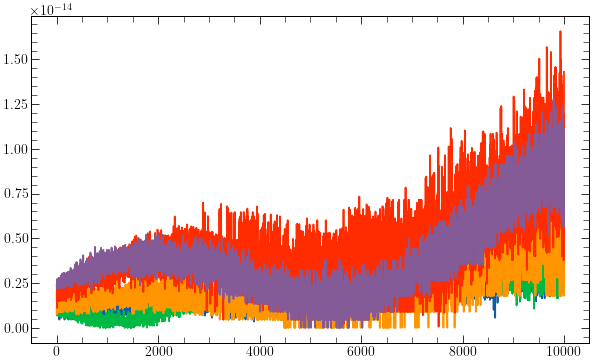

In [106]:
plt.figure(figsize=(10, 6))
for k in sol.keys():
    plt.plot(np.abs(sol[k] - solution[k]))
    
plt.show()

### Least-Squares Case

In [179]:
ls = linsolve.LinearSolver(data, wgts=wgts)
tfls = tf_linsolve.LinearSolver(data, wgts=wgts)

In [122]:
%time solution = ls.solve(mode='lsqr')

CPU times: user 308 ms, sys: 5.55 ms, total: 314 ms
Wall time: 314 ms


In [118]:
%lprun -f ls.solve ls.solve(mode='lsqr')

In [121]:
%time sol = tfls.solve(mode='lsqr', rcond=0)

CPU times: user 54.9 ms, sys: 16.9 ms, total: 71.8 ms
Wall time: 14.4 ms


In [123]:
%lprun -f tfls.solve tfls.solve(mode='lsqr', rcond=0)

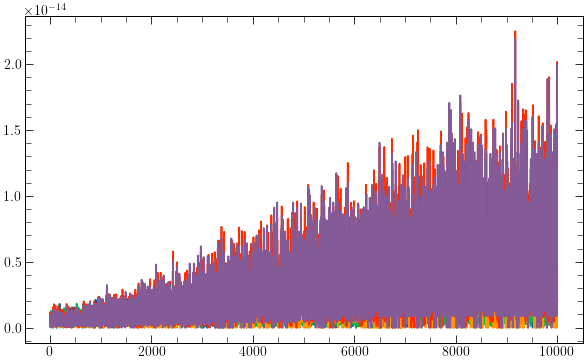

In [124]:
plt.figure(figsize=(10, 6))
for k in sol.keys():
    plt.plot(np.abs(sol[k] - solution[k]))
    
plt.show()

### Psuedo-inverse

In [125]:
%time solution = ls.solve()

CPU times: user 109 ms, sys: 14.1 ms, total: 123 ms
Wall time: 122 ms


In [126]:
%time sol = tfls.solve()

CPU times: user 281 ms, sys: 83.2 ms, total: 365 ms
Wall time: 55.2 ms


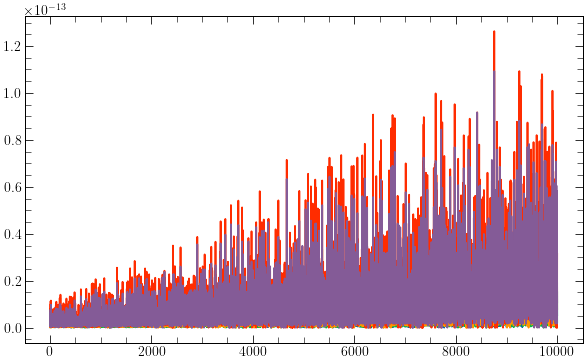

In [127]:
plt.figure(figsize=(10, 6))
for k in sol.keys():
    plt.plot(np.abs(sol[k] - solution[k]))
    
plt.show()

### Solve

In [128]:
%time solution = ls.solve(mode='solve')

CPU times: user 75.5 ms, sys: 8.56 ms, total: 84.1 ms
Wall time: 83.5 ms


In [129]:
%time sol = tfls.solve(mode='solve')

CPU times: user 86.2 ms, sys: 30.6 ms, total: 117 ms
Wall time: 20.5 ms


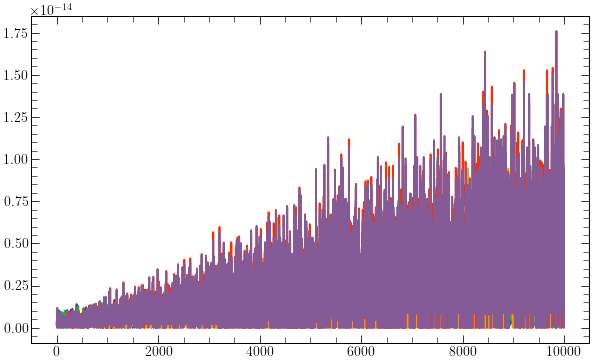

In [130]:
plt.figure(figsize=(10, 6))
for k in sol.keys():
    plt.plot(np.abs(sol[k] - solution[k]))
    
plt.show()

## Nesting Operations

In [183]:
%%timeit
A = np.zeros(ls._A_shape(), dtype=ls.dtype)
xs, ys, vals = ls.sparse_form()
ones = np.ones_like(A[0, 0])
# A[xs,ys] += [v * ones for v in vals] # This is broken when a single equation has the same param more than once
for x, y, v in zip(xs, ys, [v * ones for v in vals]):
    A[x, y] += v  # XXX ugly

3.41 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [184]:
%%timeit
A = np.zeros(ls._A_shape())
xs, ys, vals = ls.sparse_form()
ones = np.ones_like(A[0, 0])
np.add.at(A, (xs, ys), vals)

8.36 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
